# Intro Task, Object Localization

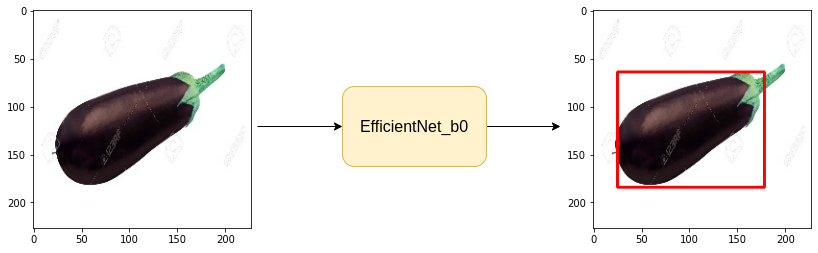

In [13]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python
!pip install opencv-contrib-python
!pip install opencv-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-k7h65fly
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-k7h65fly
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (203/203), 2.73 MiB | 6.70 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [16]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [9]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [10]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [11]:
df = pd.read_csv(CSV_FILE)
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


# Understand the dataset

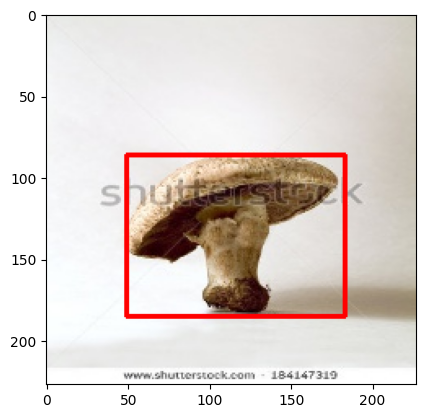

In [21]:
row = df.iloc[2]
img = cv2.imread(DATA_DIR + row.img_path)

pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
plt.imshow(bnd_box_img)

In [22]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Augmentations

In [23]:
import albumentations as A

In [24]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [25]:
valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

In [26]:
class ObjectLocalizerDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df
        self.augmentations = augmentations
    def __len__(self):
      return len(self.df)
    def __getitem__(self, index):
       row = self.df.iloc[index]
       xmin = row.xmin
       xmax = row.xmax
       ymin = row.ymin
       ymax = row.ymax
       bbox = [[xmin, ymin, xmax, ymax]]
       img_path = DATA_DIR + row.img_path
       img = cv2.imread(img_path)
       img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
       if self.augmentations:
         data = self.augmentations(image=img, bboxes=bbox, class_labels=[None])
         img = data['image']
         bbox = data['bboxes'][0]
       img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
       bbox = torch.Tensor(bbox)
       return img, bbox


In [29]:
trainset = ObjectLocalizerDataset(train_df, train_augs)
validset = ObjectLocalizerDataset(valid_df, valid_augs)

In [30]:
print("Total examples in the trainset: {}".format(len(trainset)))
print("Total examples in the validset: {}".format(len(validset)))

Total examples in the trainset: 148
Total examples in the validset: 38


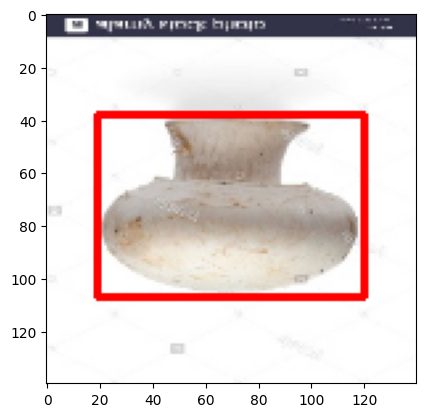

In [32]:
img, bbox = trainset[8]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [33]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)

In [34]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [35]:
for images, bboxes in trainloader:
  break

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [36]:
from torch import nn
import timm

In [37]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel, self).__init__()
    self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes = 4)
  def forward(self, images, gt_bboxes=None):
    logits = self.backbone(images)
    if gt_bboxes is not None:
      loss = nn.MSELoss()(logits, gt_bboxes)
      return logits, loss
    return logits

In [39]:
model = ObjLocModel()
model.to(DEVICE);

In [40]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [41]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train()

  for data in (dataloader):
    images, bboxes = data
    images = images.to(DEVICE)
    bboxes = bboxes.to(DEVICE)

    logits, loss = model(images, bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [42]:
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval()
  with torch.no_grad():
    for data in (dataloader):
      images, bboxes = data
      images = images.to(DEVICE)
      bboxes = bboxes.to(DEVICE)

      logits, loss = model(images, bboxes)
      total_loss += loss.item()

  return total_loss / len(dataloader)

#Training Loop

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [44]:
best_valid_loss = np.inf
for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("WEIGHTS ARE SAVED")
    best_valid_loss = valid_loss

  print("Epoch : {} | Train Loss : {} | Valid Loss : {}".format(i+1, train_loss, valid_loss))

WEIGHTS ARE SAVED
Epoch : 1 | Train Loss : 5225.496362304688 | Valid Loss : 3061.94970703125
Epoch : 2 | Train Loss : 1815.6754211425782 | Valid Loss : 3443.594482421875
WEIGHTS ARE SAVED
Epoch : 3 | Train Loss : 1088.2258544921874 | Valid Loss : 333.1895446777344
WEIGHTS ARE SAVED
Epoch : 4 | Train Loss : 640.0076446533203 | Valid Loss : 220.68762715657553
Epoch : 5 | Train Loss : 505.6195861816406 | Valid Loss : 328.4009195963542
WEIGHTS ARE SAVED
Epoch : 6 | Train Loss : 324.4414001464844 | Valid Loss : 193.00255330403647
Epoch : 7 | Train Loss : 255.0692153930664 | Valid Loss : 266.6616923014323
WEIGHTS ARE SAVED
Epoch : 8 | Train Loss : 189.56086044311525 | Valid Loss : 160.7702382405599
WEIGHTS ARE SAVED
Epoch : 9 | Train Loss : 150.9891143798828 | Valid Loss : 147.9648183186849
Epoch : 10 | Train Loss : 116.57911911010743 | Valid Loss : 203.0470428466797
Epoch : 11 | Train Loss : 137.18873329162597 | Valid Loss : 149.7732899983724
WEIGHTS ARE SAVED
Epoch : 12 | Train Loss : 96.8

#Inference

In [46]:
import utils

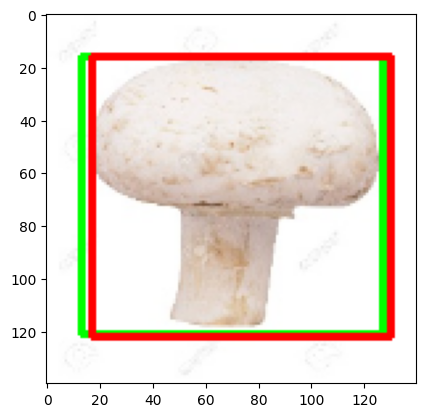

In [47]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
  image, gt_bbox = validset[1]
  image = image.unsqueeze(0).to(DEVICE)
  out_bbox = model(image)
  utils.compare_plots(image, gt_bbox, out_bbox)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya